In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud

In [2]:
df_clean = pd.read_csv('../data/vnexpress_raw_data.csv',encoding='utf-8')

# 1. Xử lý dữ liệu thiếu

In [3]:
# Hiển thị số lượng giá trị thiếu trước khi xử lý
print("Số lượng giá trị thiếu trước khi xử lý:")
missing_before = df_clean.isnull().sum()
missing_percentage_before = (df_clean.isnull().sum() / len(df_clean) * 100).round(2)
pd.DataFrame({
    'Giá Trị Thiếu': missing_before,
    'Phần Trăm (%)': missing_percentage_before
})

Số lượng giá trị thiếu trước khi xử lý:


,Giá Trị Thiếu,Phần Trăm (%)
title,0,0.00
description,2,0.17
date,2,0.17
category,56,4.73
thumbnail,41,3.46
content,3,0.25
author,252,21.28
tags,0,0.00
group,0,0.00
nums_of_comments,0,0.00


In [4]:
df_clean.fillna({
    'description': '',
    'category': 'Khác',
    'thumbnail': 'No Image',
    'author': 'Không xác định',
    'content': '',
}, inplace=True)

# drop date column null
df_clean.dropna(subset=['date'], inplace=True)

# Kiểm tra lại sau khi điền giá trị thiếu
print("Số lượng giá trị thiếu sau khi xử lý:")
missing_after = df_clean.isnull().sum()
missing_percentage_after = (df_clean.isnull().sum() / len(df_clean) * 100).round(2)
pd.DataFrame({
    'Giá Trị Thiếu': missing_after,
    'Phần Trăm (%)': missing_percentage_after
})

Số lượng giá trị thiếu sau khi xử lý:


,Giá Trị Thiếu,Phần Trăm (%)
title,0,0.0
description,0,0.0
date,0,0.0
category,0,0.0
thumbnail,0,0.0
content,0,0.0
author,0,0.0
tags,0,0.0
group,0,0.0
nums_of_comments,0,0.0


# 2. Làm sạch dữ liệu văn bản

In [5]:
def clean_text(text):
    if pd.isna(text):
        return ""
        
    # Loại bỏ HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Loại bỏ URL
    text = re.sub(r'http\S+', ' ', text)
    # Loại bỏ ký tự đặc biệt và số
    text = re.sub(r'[^\w\s]', ' ', text)
    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Áp dụng hàm làm sạch cho các cột văn bản
df_clean['content_cleaned'] = df_clean['content'].apply(clean_text)
df_clean['description_cleaned'] = df_clean['description'].apply(clean_text)
df_clean['title_cleaned'] = df_clean['title'].apply(clean_text)

# Kiểm tra độ dài của các cột văn bản trước và sau khi làm sạch
df_clean['content_length'] = df_clean['content'].apply(len)
df_clean['description_length'] = df_clean['description'].apply(len)
df_clean['title_length'] = df_clean['title'].apply(len)

# Tính độ dài sau khi làm sạch
df_clean['content_cleaned_length'] = df_clean['content_cleaned'].apply(len)
df_clean['description_cleaned_length'] = df_clean['description_cleaned'].apply(len)
df_clean['title_cleaned_length'] = df_clean['title_cleaned'].apply(len)

In [6]:
# So sánh độ dài trước và sau khi làm sạch
comparison = pd.DataFrame({
    'Tiêu đề (Trước)': df_clean['title_length'].describe(),
    'Tiêu đề (Sau)': df_clean['title_cleaned_length'].describe(),
    'Mô tả (Trước)': df_clean['description_length'].describe(),
    'Mô tả (Sau)': df_clean['description_cleaned_length'].describe(),
    'Nội dung (Trước)': df_clean['content_length'].describe(),
    'Nội dung (Sau)': df_clean['content_cleaned_length'].describe()
}).round(2)

comparison

,Tiêu đề (Trước),Tiêu đề (Sau),Mô tả (Trước),Mô tả (Sau),Nội dung (Trước),Nội dung (Sau)
count,1182.00,1182.00,1182.00,1182.00,1182.00,1182.00
mean,49.48,48.94,138.93,136.27,2928.64,2860.14
std,10.32,10.18,22.65,22.33,1818.53,1774.09
min,17.00,17.00,78.00,75.00,0.00,0.00
25%,42.00,42.00,124.00,122.00,1944.50,1894.25
50%,50.00,49.50,137.00,134.00,2583.50,2519.00
75%,56.00,56.00,151.00,147.75,3574.00,3491.75
max,79.00,79.00,224.00,221.00,12612.00,12269.00


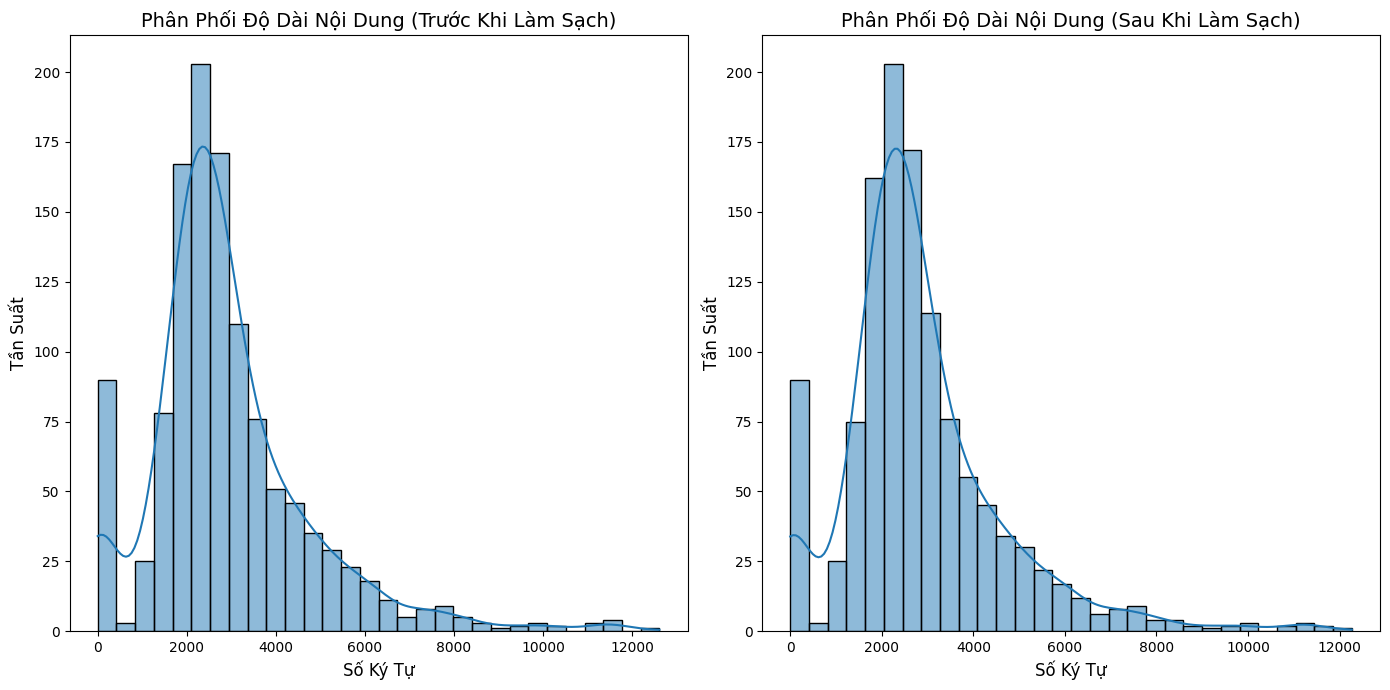

In [7]:
# Trực quan hóa sự thay đổi trước và sau khi làm sạch cho độ dài nội dung
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.histplot(data=df_clean['content_length'], kde=True, bins=30)
plt.title('Phân Phối Độ Dài Nội Dung (Trước Khi Làm Sạch)', fontsize=14)
plt.xlabel('Số Ký Tự', fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)

plt.subplot(1, 2, 2)
sns.histplot(data=df_clean['content_cleaned_length'], kde=True, bins=30)
plt.title('Phân Phối Độ Dài Nội Dung (Sau Khi Làm Sạch)', fontsize=14)
plt.xlabel('Số Ký Tự', fontsize=12)
plt.ylabel('Tần Suất', fontsize=12)

plt.tight_layout()
plt.show()

# 3. Chuyển đổi kiểu dữ liệu
## Tags: String -> List, Xử lý Author bị lỗi khi thu nhập

In [8]:
# Xử lý cột tags
df_clean['tags_list'] =  df_clean['tags'].str.split(',').apply(lambda x: [tag.strip() for tag in x])
df_clean['tags_count'] = df_clean['tags_list'].apply(len)

print("Số lượng tags trung bình mỗi bài viết:", df_clean['tags_count'].mean())
print("Số lượng tác giả trước khi làm sạch:", df_clean['author'].nunique())
# Xử lý cột author (loại bỏ phần trong ngoặc)
df_clean['author_cleaned'] = df_clean['author'].apply(lambda x: re.sub(r'\s*\(.*?\)', '', str(x)).strip())
# loại bỏ các ký tự không cần thiết 
df_clean['author_cleaned'] = df_clean['author_cleaned'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)).strip())

print("Số lượng tags trung bình mỗi bài viết:", df_clean['tags_count'].mean())
print("Số lượng tác giả khác nhau sau khi làm sạch:", df_clean['author_cleaned'].nunique())

Số lượng tags trung bình mỗi bài viết: 3.8790186125211505
Số lượng tác giả trước khi làm sạch: 307
Số lượng tags trung bình mỗi bài viết: 3.8790186125211505
Số lượng tác giả khác nhau sau khi làm sạch: 151


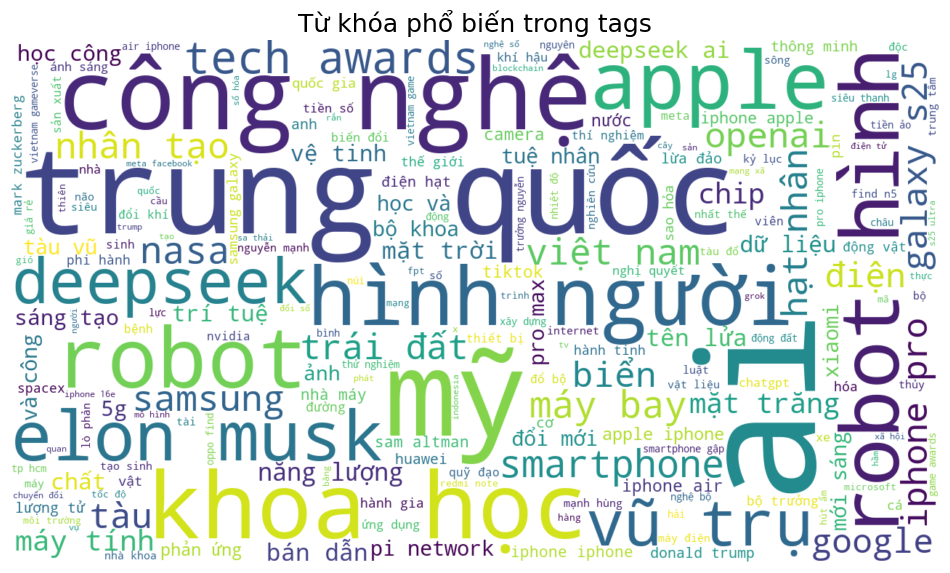

In [9]:

all_tags = ', '.join([', '.join(tags) for tags in df_clean['tags_list']])
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=1280, height=720, background_color='white', max_words=200, contour_width=3).generate(all_tags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Từ khóa phổ biến trong tags', fontsize=18)
plt.show()

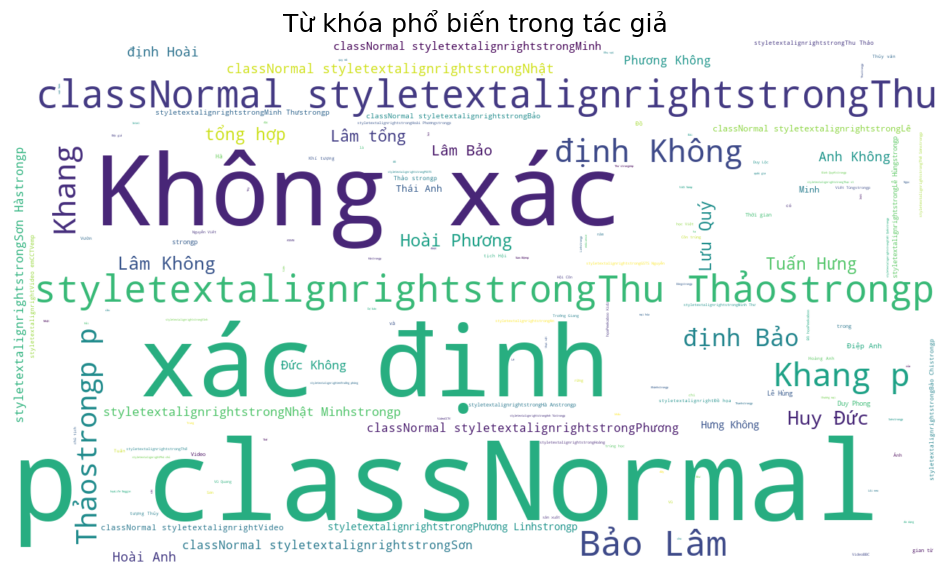

In [10]:

# all_tags = ', '.join([', '.df_clean['author_cleaned']])
all_tags = ', '.join(df_clean['author_cleaned'].astype(str).tolist())
plt.figure(figsize=(12, 8))
wordcloud = WordCloud(width=1280, height=720, background_color='white', max_words=200, contour_width=3).generate(all_tags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Từ khóa phổ biến trong tác giả', fontsize=18)
plt.show()

# 4. Chuyển đổi kiểu dữ liệu
## Chuẩn hóa dữ liệu thời gian

In [11]:
# Chuẩn hóa cột ngày tháng
df_clean['date_clean'] = df_clean['date'].str.split(', ', n=1).str[1]
df_clean['date'] = pd.to_datetime(df_clean['date_clean'], format='%d/%m/%Y, %H:%M (GMT+7)', errors='coerce')

# Tạo các đặc trưng thời gian
df_clean['year'] = df_clean['date'].dt.year
df_clean['month'] = df_clean['date'].dt.month
df_clean['day'] = df_clean['date'].dt.day
df_clean['hour'] = df_clean['date'].dt.hour
df_clean['day_of_week'] = df_clean['date'].dt.dayofweek  # 0 là Monday, 6 là Sunday

# Kiểm tra giá trị null sau khi chuyển đổi
print(f"Số lượng giá trị ngày tháng hợp lệ: {df_clean['date'].notnull().sum()} ({df_clean['date'].notnull().sum()/len(df_clean)*100:.2f}%)")
print(f"Số lượng giá trị ngày tháng không hợp lệ: {df_clean['date'].isnull().sum()} ({df_clean['date'].isnull().sum()/len(df_clean)*100:.2f}%)")

Số lượng giá trị ngày tháng hợp lệ: 1182 (100.00%)
Số lượng giá trị ngày tháng không hợp lệ: 0 (0.00%)


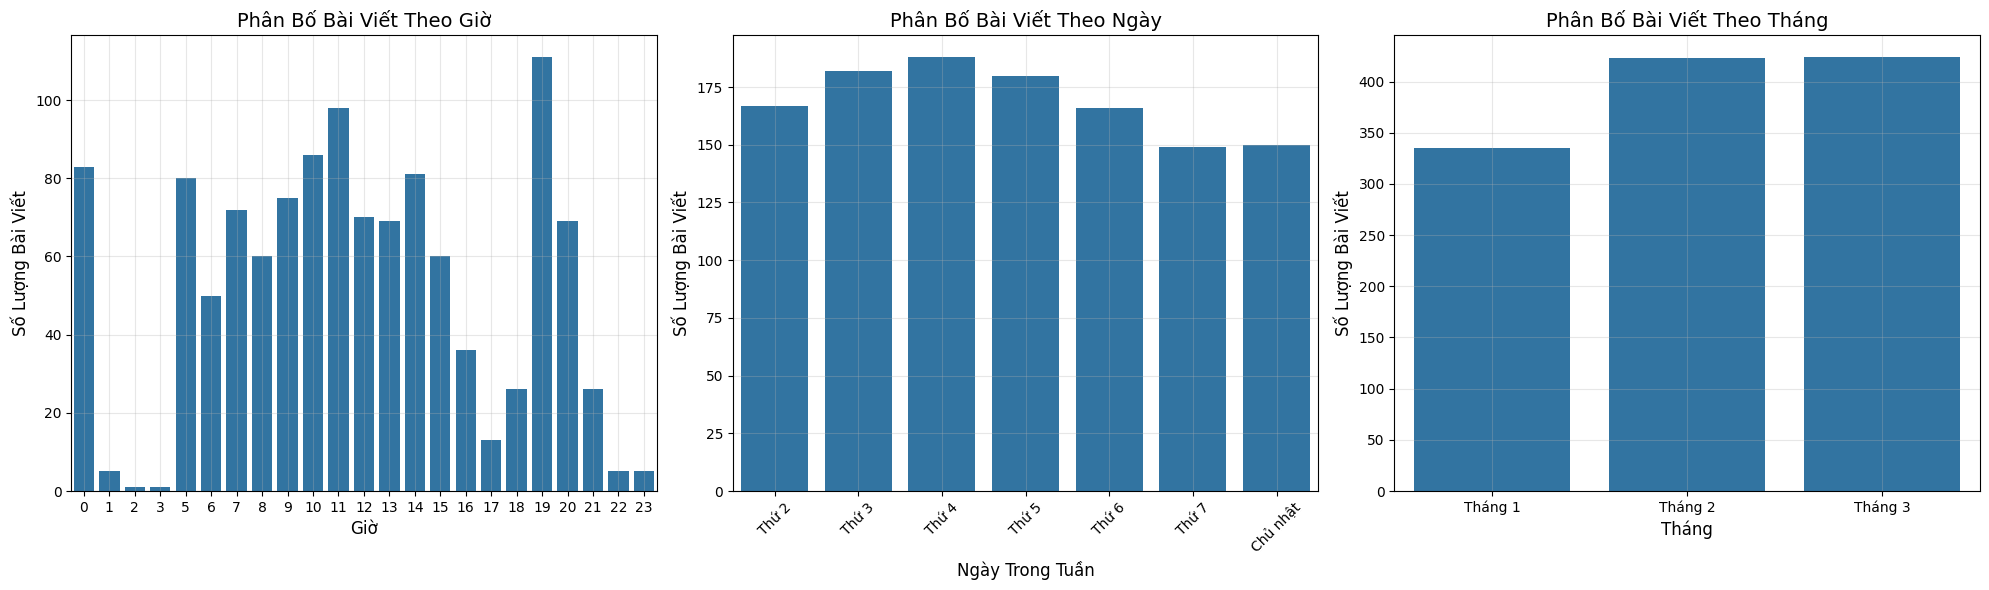

In [12]:
# Tạo figure với 3 subplot nằm ngang
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Biểu đồ phân bố theo giờ trong ngày
hour_counts = df_clean['hour'].value_counts().sort_index()
sns.barplot(x=hour_counts.index, y=hour_counts.values, ax=axes[0])
axes[0].set_title('Phân Bố Bài Viết Theo Giờ', fontsize=14)
axes[0].set_xlabel('Giờ', fontsize=12)
axes[0].set_ylabel('Số Lượng Bài Viết', fontsize=12)
axes[0].set_xticks(range(len(hour_counts)))
axes[0].set_xticklabels([f'{h}' for h in hour_counts.index])
axes[0].grid(True, alpha=0.3)

# 2. Biểu đồ phân bố theo ngày trong tuần
days = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ nhật']
day_counts = df_clean['day_of_week'].value_counts().sort_index()
sns.barplot(x=day_counts.index, y=day_counts.values, ax=axes[1])
axes[1].set_title('Phân Bố Bài Viết Theo Ngày', fontsize=14)
axes[1].set_xlabel('Ngày Trong Tuần', fontsize=12)
axes[1].set_ylabel('Số Lượng Bài Viết', fontsize=12)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(days, rotation=45)
axes[1].grid(True, alpha=0.3)

# 3. Biểu đồ phân bố theo tháng
month_counts = df_clean['month'].value_counts().sort_index()
sns.barplot(x=month_counts.index, y=month_counts.values, ax=axes[2])
axes[2].set_title('Phân Bố Bài Viết Theo Tháng', fontsize=14)
axes[2].set_xlabel('Tháng', fontsize=12)
axes[2].set_ylabel('Số Lượng Bài Viết', fontsize=12)
axes[2].set_xticks(range(len(month_counts)))
axes[2].set_xticklabels([f'Tháng {m}' for m in month_counts.index])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

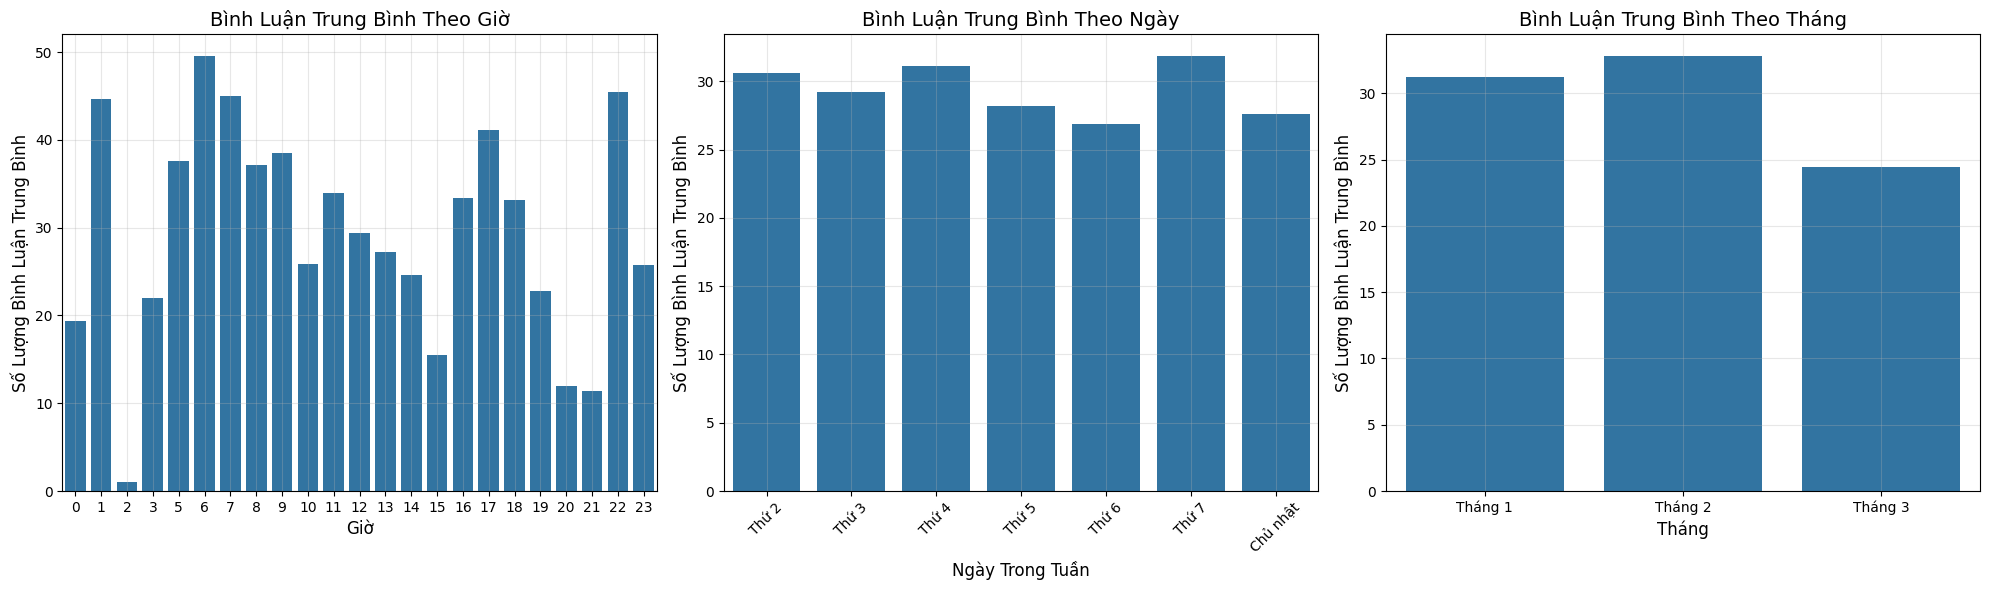

In [13]:
# Tạo biểu đồ phân bố bình luận trung bình theo giờ, ngày và tháng
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Biểu đồ phân bố bình luận trung bình theo giờ
comments_by_hour = df_clean.groupby('hour')['nums_of_comments'].mean().sort_index()
sns.barplot(x=comments_by_hour.index, y=comments_by_hour.values, ax=axes[0])
axes[0].set_title('Bình Luận Trung Bình Theo Giờ', fontsize=14)
axes[0].set_xlabel('Giờ', fontsize=12)
axes[0].set_ylabel('Số Lượng Bình Luận Trung Bình', fontsize=12)
axes[0].set_xticks(range(len(comments_by_hour)))
axes[0].set_xticklabels([f'{h}' for h in comments_by_hour.index])
axes[0].grid(True, alpha=0.3)

# 2. Biểu đồ phân bố bình luận theo ngày trong tuần
comments_by_day = df_clean.groupby('day_of_week')['nums_of_comments'].mean().sort_index()
days = ['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ nhật']
sns.barplot(x=comments_by_day.index, y=comments_by_day.values, ax=axes[1])
axes[1].set_title('Bình Luận Trung Bình Theo Ngày', fontsize=14)
axes[1].set_xlabel('Ngày Trong Tuần', fontsize=12)
axes[1].set_ylabel('Số Lượng Bình Luận Trung Bình', fontsize=12)
axes[1].set_xticks(range(7))
axes[1].set_xticklabels(days, rotation=45)
axes[1].grid(True, alpha=0.3)

# 3. Biểu đồ phân bố bình luận theo tháng
comments_by_month = df_clean.groupby('month')['nums_of_comments'].mean().sort_index()
sns.barplot(x=comments_by_month.index, y=comments_by_month.values, ax=axes[2])
axes[2].set_title('Bình Luận Trung Bình Theo Tháng', fontsize=14)
axes[2].set_xlabel('Tháng', fontsize=12)
axes[2].set_ylabel('Số Lượng Bình Luận Trung Bình', fontsize=12)
axes[2].set_xticks(range(len(comments_by_month)))
axes[2].set_xticklabels([f'Tháng {m}' for m in comments_by_month.index])
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 5. Xử lý Outlier

In [15]:
# Xử lý Outlier với Nums_of_comments
df_clean.describe().T

,count,mean,min,25%,50%,75%,max,std
date,1182,2025-02-18 00:56:21.675126784,2025-01-06 05:00:00,2025-01-28 19:00:00,2025-02-17 12:39:30,2025-03-10 10:46:30,2025-03-31 19:38:00,NaN
nums_of_comments,1182.0,29.354484,0.0,3.0,12.0,33.0,389.0,47.330145
content_length,1182.0,2928.637902,0.0,1944.5,2583.5,3574.0,12612.0,1818.529936
description_length,1182.0,138.928934,78.0,124.0,137.0,151.0,224.0,22.649037
title_length,1182.0,49.481387,17.0,42.0,50.0,56.0,79.0,10.319662
content_cleaned_length,1182.0,2860.138748,0.0,1894.25,2519.0,3491.75,12269.0,1774.090282
description_cleaned_length,1182.0,136.27242,75.0,122.0,134.0,147.75,221.0,22.326427
title_cleaned_length,1182.0,48.935702,17.0,42.0,49.5,56.0,79.0,10.177806
tags_count,1182.0,3.879019,1.0,3.0,3.0,5.0,13.0,1.856334
year,1182.0,2025.0,2025.0,2025.0,2025.0,2025.0,2025.0,0.0


## 5.1. Phân tích outlier trước khi xử lý

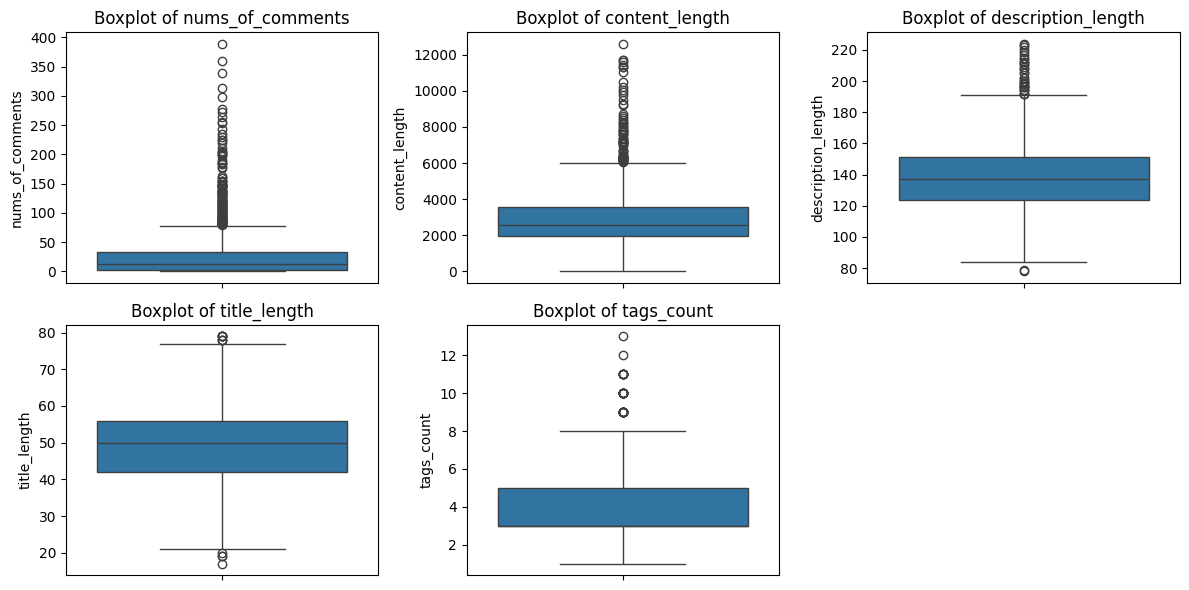

,column,min,max,mean,median,lower_bound,upper_bound,outliers_count,outliers_percent
0,nums_of_comments,0,389,29.354484,12.0,-42.00,78.00,124,10.490694
1,content_length,0,12612,2928.637902,2583.5,-499.75,6018.25,71,6.006768
2,description_length,78,224,138.928934,137.0,83.50,191.50,37,3.130288
3,title_length,17,79,49.481387,50.0,21.00,77.00,12,1.015228
4,tags_count,1,13,3.879019,3.0,0.00,8.00,38,3.214890


In [33]:
# Vẽ boxplot để phát hiện outlier trong các trường số
plt.figure(figsize=(12, 6))

# Các trường số liệu cần kiểm tra outlier
numeric_cols = ['nums_of_comments', 'content_length', 'description_length', 
                'title_length', 'tags_count']

for i, col in enumerate(numeric_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df_clean[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    
plt.show()

# Hiển thị thống kê chi tiết về các trường này
stats_df = pd.DataFrame()
for col in numeric_cols:
    q1 = df_clean[col].quantile(0.25)
    q3 = df_clean[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)][col].count()
    outlier_percent = outliers / len(df_clean) * 100
    
    stats = {
        'column': col,
        'min': df_clean[col].min(),
        'max': df_clean[col].max(),
        'mean': df_clean[col].mean(),
        'median': df_clean[col].median(),
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'outliers_count': outliers,
        'outliers_percent': outlier_percent
    }
    stats_df = pd.concat([stats_df, pd.DataFrame([stats])], ignore_index=True)

stats_df

## 5.2. Xử lý outlier với nhiều phương pháp 

In [29]:
# Tạo bản sao để so sánh trước và sau khi xử lý
df_before_outlier = df_clean.copy()

# 1. Phương pháp 1: Cắt ngưỡng (Trimming/Capping)
def cap_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    df_capped = df.copy()
    df_capped.loc[df_capped[column] < lower_bound, column] = lower_bound
    df_capped.loc[df_capped[column] > upper_bound, column] = upper_bound
    return df_capped

# 2. Phương pháp 2: Chuyển đổi logarit (Log transformation)
def log_transform(df, column):
    df_log = df.copy()
    # Thêm 1 để tránh log(0)
    df_log[f'{column}_log'] = np.log1p(df_log[column])
    return df_log

# 3. Phương pháp 3: Winsorization (thay thế bằng phân vị)
def winsorize(df, column, limits=[0.05, 0.05]):
    from scipy.stats.mstats import winsorize
    df_win = df.copy()
    df_win[column] = winsorize(df_win[column], limits=limits)
    return df_win

# Áp dụng các phương pháp xử lý outlier
df_capped = df_clean.copy()
for col in ['nums_of_comments', 'content_length']:
    df_capped = cap_outliers(df_capped, col)

# Hoặc winsorize
df_winsorized = df_clean.copy()
for col in ['nums_of_comments', 'content_length']:
    df_winsorized = winsorize(df_winsorized, col)

# Log transform cho các biến có phân phối lệch dương
df_log = df_clean.copy()
df_log['nums_of_comments_log'] = np.log1p(df_log['nums_of_comments'])

C:\Users\toany\AppData\Local\Temp\ipykernel_30668\2653105285.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-499.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_capped.loc[df_capped[column] < lower_bound, column] = lower_bound


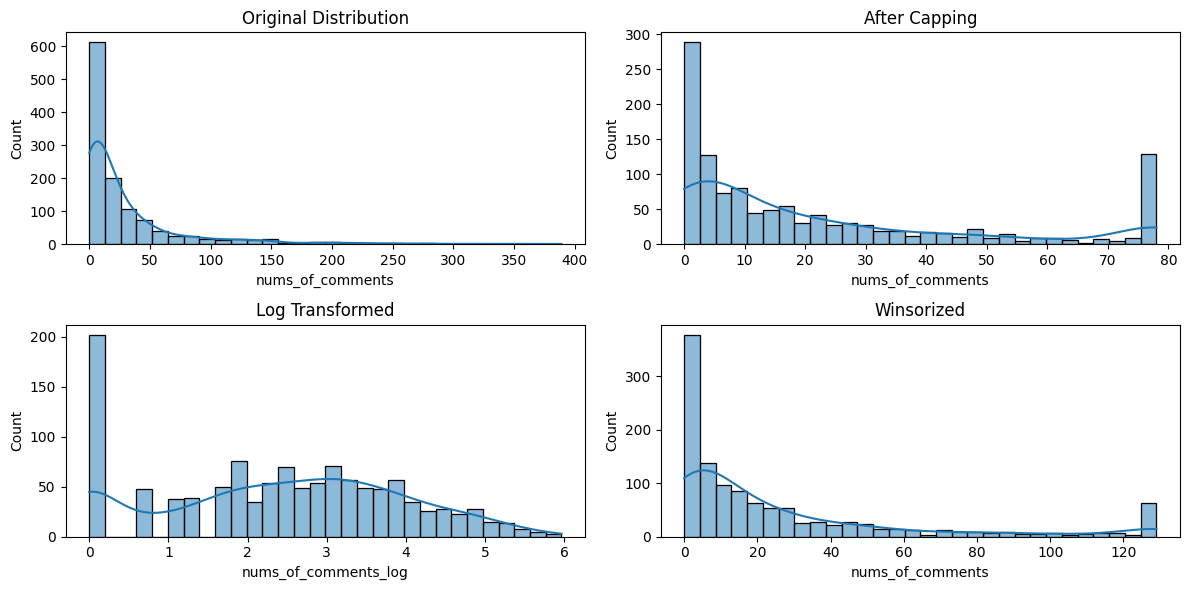

In [32]:
# So sánh phân phối trước và sau khi xử lý outlier
plt.figure(figsize=(12, 6))

# Ví dụ với 'nums_of_comments'
plt.subplot(2, 2, 1)
sns.histplot(df_clean['nums_of_comments'], kde=True, bins=30)
plt.title('Original Distribution')

plt.subplot(2, 2, 2)
sns.histplot(df_capped['nums_of_comments'], kde=True, bins=30)
plt.title('After Capping')

plt.subplot(2, 2, 3)
sns.histplot(df_log['nums_of_comments_log'], kde=True, bins=30)
plt.title('Log Transformed')

plt.subplot(2, 2, 4)
sns.histplot(df_winsorized['nums_of_comments'], kde=True, bins=30)
plt.title('Winsorized')

plt.tight_layout()
plt.show()

## 6. Xuất data_clean

In [16]:
cols_final = ['title_cleaned_length', 'description_cleaned_length', 'content_cleaned_length', 'content_cleaned', 
              'title_cleaned', 'description_cleaned', 'tags_count', 'tags_list', 'category', 'nums_of_comments', 
              'hour', 'day_of_week', 'month', 'year', 'author_cleaned']

df_clean_final = df_clean[cols_final].copy()
df_clean_final['nums_of_comments'] = df_clean_final['nums_of_comments']
df_clean_final['tags_count'] = df_clean_final['tags_count']
df_clean_final['hour'] = df_clean_final['hour']
df_clean_final['day_of_week'] = df_clean_final['day_of_week']
df_clean_final['month'] = df_clean_final['month']
df_clean_final['year'] = df_clean_final['year']
df_clean_final['category'] = df_clean_final['category']
df_clean_final['author'] = df_clean_final['author_cleaned']
df_clean_final['tags_list'] = df_clean_final['tags_list']
df_clean_final['content'] = df_clean_final['content_cleaned']
df_clean_final['title'] = df_clean_final['title_cleaned']
df_clean_final['description'] = df_clean_final['description_cleaned']
df_clean_final['content_length'] = df_clean_final['content_cleaned_length']
df_clean_final['title_length'] = df_clean_final['title_cleaned_length']
df_clean_final['description_length'] = df_clean_final['description_cleaned_length']


In [17]:
df_clean_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1182 entries, 0 to 1183
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   title_cleaned_length        1182 non-null   int64 
 1   description_cleaned_length  1182 non-null   int64 
 2   content_cleaned_length      1182 non-null   int64 
 3   content_cleaned             1182 non-null   object
 4   title_cleaned               1182 non-null   object
 5   description_cleaned         1182 non-null   object
 6   tags_count                  1182 non-null   int64 
 7   tags_list                   1182 non-null   object
 8   category                    1182 non-null   object
 9   nums_of_comments            1182 non-null   int64 
 10  hour                        1182 non-null   int32 
 11  day_of_week                 1182 non-null   int32 
 12  month                       1182 non-null   int32 
 13  year                        1182 non-null   int32 
 1